# nuSQuIDS decoherence in atmopsheric neutrinos example

This notebook demonstrates how to calculate oscillation probabilities for atmopsheric neutrinos in the presence of decoherence effects.

We use mathematical formalism defined in https://arxiv.org/abs/0805.2098.

Oscillation probabilities are calculated in 2D, w.r.t. energy and zenith angle. The energies and baselines shown are chosen to be relevent for a neutrino telescope like DeepCore.

Contact Tom Stuttard (stuttard@nbi.ku.dk) with questions/issues.

In [1]:
import collections, datetime

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import nuSQUIDSpy as nsq

## Configuring nuSQuIDS

In [50]:
# Units container
units = nsq.Const()

# Define neutrino flavors/states
flavs = [0,1,2]
flavs_tex = [r"\nu_e",r"\nu_{\mu}",r"\nu_{\tau}"]

# Define a grid in [energy,cos(zenith angle)]
grid_size = 100
energy_nodes = np.logspace(0.,3.,num=grid_size)
coszen_nodes = np.linspace(-1.,1.,num=grid_size)
energy_grid,coszen_grid = np.meshgrid(energy_nodes,coszen_nodes)

# Decide whether to consider neutrino interacions with matter whilst crossing the Earth
# This allows Earth absoprtion, tau regeneration, etc to be computed, but is slower
# For DeepCore energies, can safely negelct this
interactions = False

# Only consiering neutrinos (no antineutrinos) for now
nu_nubar = nsq.NeutrinoType.neutrino

# Instantiate nuSQuIDSAtm (decoherence version)
nusquids = nsq.nuSQUIDSAtmDecoh(coszen_nodes,energy_nodes*units.GeV,len(flavs),nu_nubar,interactions)

# Don't want debug printing
nusquids.Set_Debug(False)

# Set tolerance for numerical solving the oscillation probabilities
error = 1.e-4
nusquids.Set_rel_error(error)
nusquids.Set_abs_error(error)

## Choose decoherence parameters

In [58]:
# Defining the decoherence using 3 damping parameters [eV]
gamma21 = 2.e-14
gamma31 = 2.e-14
gamma32 = 2.e-14
nusquids.Set_DecoherenceGammaMatrix(gamma21,gamma31,gamma32)

# Show the resulting 3x3 matrix
print "Decoherence Gamma matrix:"
print nusquids.Get_DecoherenceGammaMatrix()

# Define energy dependence
energy_index = 0
nusquids.Set_DecoherenceGammaEnergyDependence(energy_index)

# Show the internal value as a check
print "\nDecoherence Gamma energy dependence:"
print nusquids.Get_DecoherenceGammaEnergyDependence() 

Decoherence Gamma matrix:
[[0.e+00 2.e-14 2.e-14]
 [2.e-14 0.e+00 2.e-14]
 [2.e-14 2.e-14 0.e+00]]

Decoherence Gamma energy dependence:
0.0


## Calculate oscillation probability

In [59]:
# Choose initial state
# Here starting as 100% muon neutrino
initial_flav = 1

# Container for the calculated poscillation probability
prob_results = collections.OrderedDict()

# Calculate for standard oscillations and for decoherence cases
for enable_decoherence,color in zip([False,True],["blue","red"]) :

    start_time = datetime.datetime.now()
    
    # Enable/disable decoherence effects
    nusquids.EnableDecoherence(enable_decoherence)
    physics_model = "decoherence" if enable_decoherence else "standard oscillations"

    
    #
    # Set initial state
    #

    # Need to fill an array with initial flux values.
    # Set flux to 1 for initial state neutrino, 0 for everything else (since we
    # are calcualting osc probability).
    # Need to do this for each point in a [coszen,E,flavor] grid.
    # Also need a nu/nubar dimension in this grid if using both nu and antinu. 

    if nu_nubar == nsq.NeutrinoType.both :
        initial_state  = np.full((nusquids.GetNumCos(),nusquids.GetNumE(),2,len(flavs)),np.NaN)
    else :
        initial_state  = np.full((nusquids.GetNumCos(),nusquids.GetNumE(),len(flavs)),np.NaN)

    for i_c in range(0,nusquids.GetNumCos()) :
        for i_e in range(0,nusquids.GetNumE()) :
            for flav in flavs :
                flux = 1. if flav == initial_flav else 0. # Set flux to 1 for `initial_fig`, else 0
                if nu_nubar == nsq.NeutrinoType.both :
                    for rho in range(0,2) :
                        initial_state[i_c,i_e,rho,flav] = flux
                else :
                    initial_state[i_c,i_e,flav] = flux

    #Actually set the state
    nusquids.Set_initial_state(initial_state,nsq.Basis.flavor)
            

    #
    # Compute flavors
    #

    # Evolve the states
    nusquids.EvolveState()

    # Get the evolved flux values
    rho = 0 # nu (as opposed to nubar)
    phi = np.full([energy_nodes.size,coszen_nodes.size,len(flavs)],np.NaN)
    for i_E,E in enumerate(energy_nodes) :
        for i_cz,cz in enumerate(coszen_nodes) :
            for flav in flavs :
                phi[i_E,i_cz,flav] = nusquids.EvalFlavor(flav,cz,E*units.GeV,rho)
                
    # Store the results
    prob_results[physics_model] = phi

    end_time = datetime.datetime.now()

    print "Took %s for %s" % (end_time-start_time,physics_model)

Took 0:00:00.529368 for standard oscillations
Took 0:00:01.904237 for decoherence


## Plot oscillograms

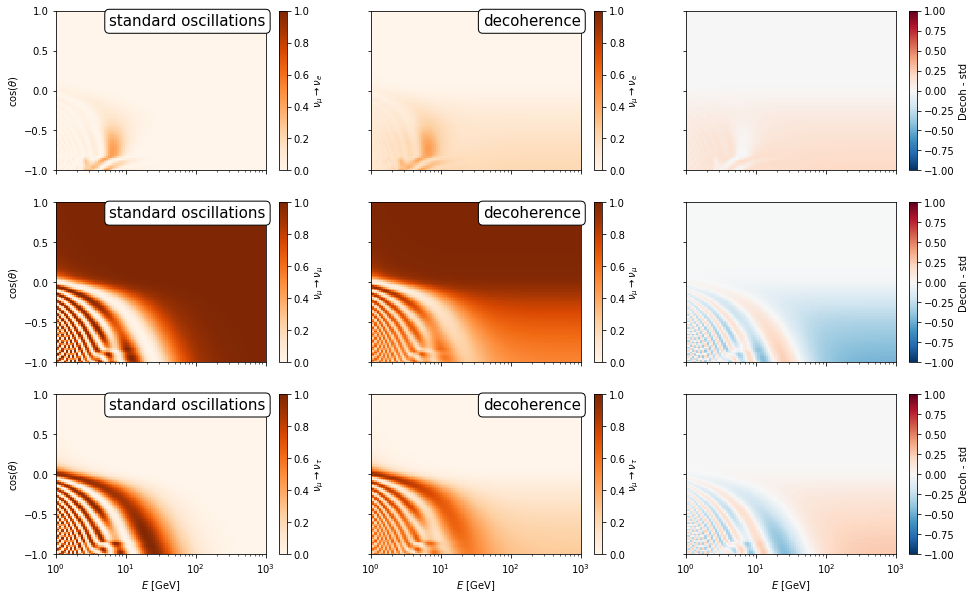

In [67]:
# A plot to fill
fig,ax = plt.subplots(len(flavs),len(prob_results)+1,sharex=True,sharey=True,figsize=(16,10))

# Get tex for initial flavor
initial_flav_tex = flavs_tex[initial_flav]

# Loop over final state flavors
for i_flav,(final_flav,final_flav_tex) in enumerate(zip(flavs,flavs_tex)) :
    
    # Transition probability tex
    trans_tex = r"$%s \rightarrow %s$" % (initial_flav_tex,final_flav_tex)
        
    # Loop over the physics cases
    for i_phys,(physics_model,osc_probs) in enumerate(prob_results.items()) :
    
        # Plot the oscillogram for this combination of initial and final states
        cmesh = ax[i_flav,i_phys].pcolormesh( energy_nodes, coszen_nodes, osc_probs[:,:,final_flav].T, vmin=0., vmax=1., cmap="Oranges" )
        cbar = fig.colorbar( cmesh, ax=ax[i_flav,i_phys], label=trans_tex )
        
        # Add a label indicating physics case
        ax[i_flav,i_phys].text(1., 0.98, physics_model, ha="right", va="top", transform=ax[i_flav,i_phys].transAxes, fontsize=15, bbox={'facecolor':'white', 'edgecolor':"black", "boxstyle":'round'} )
            
    # Plot the difference between the standard oscillations and the decoherence case
    diff = prob_results["decoherence"][:,:,final_flav] - prob_results["standard oscillations"][:,:,final_flav]
    cmesh = ax[i_flav,-1].pcolormesh( energy_nodes, coszen_nodes, diff.T, vmin=-1., vmax=1., cmap="RdBu_r" )
    cbar = fig.colorbar( cmesh, ax=ax[i_flav,-1], label="Decoh - std" )
        
# Format
for a in ax[:,0].flatten() :
    a.set_ylabel(r"$\cos(\theta)$")
for a in ax[-1,:].flatten() :
    a.set_xlabel(r"$E$ [GeV]")
for a in ax.flatten() :
    a.set_xscale('log')